case study telecom churn classifies problem
http://blog.insightdatalabs.com/visualizing-classifier-thresholds/
https://github.com/InsightDataLabs/ipython-notebooks/blob/master/classifier_thresholds.ipynb


In [1]:
import pandas as pd  
import numpy as np

In [2]:
from sklearn.cross_validation import train_test_split  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import precision_recall_curve  
from sklearn.preprocessing import LabelEncoder


In [3]:
 #Retrieve Data Set
df = pd.read_csv('http://www.dataminingconsultant.com/data/churn.txt')


# Some Prepreocessing
df.columns = [c.lower().replace(' ', '_').replace('?', '').replace("'", "") for c in df.columns]

state_encoder = LabelEncoder()  
df.state = state_encoder.fit_transform(df.state)

del df['phone']

binary_columns = ['intl_plan', 'vmail_plan', 'churn']  
for col in binary_columns:  
    df[col] = df[col].map({
            'no': 0
        ,   'False.': 0
        ,   'yes': 1
        ,   'True.': 1
    })

df.head()



,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [4]:
# Build the classifier and get the predictions
clf = RandomForestClassifier(n_estimators=50, oob_score=True)  
test_size_percent = 0.1

signals = df[[c for c in df.columns if c != 'churn']]  
labels = df['churn']

train_signals, test_signals, train_labels, test_labels = train_test_split(signals, labels, test_size=test_size_percent)  
clf.fit(train_signals, train_labels)  
predictions = clf.predict_proba(test_signals)[:,1]  


Now let's see what the performance of this model is as a function of the threshold. We'll use the handy precision_recall_curve function from sklearn



Populating the interactive namespace from numpy and matplotlib


/Users/tatianaovchinnikova/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


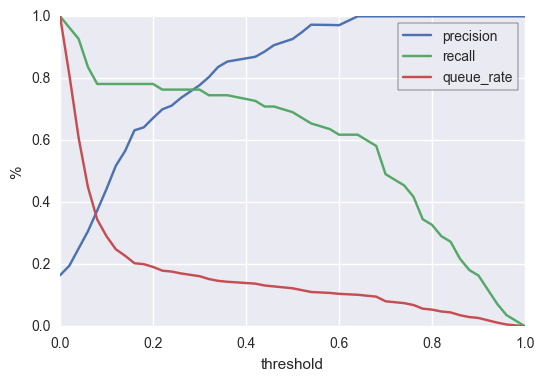

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
%pylab inline

precision, recall, thresholds = precision_recall_curve(test_labels, predictions)  
thresholds = np.append(thresholds, 1)

queue_rate = []  
for threshold in thresholds:  
    queue_rate.append((predictions >= threshold).mean())

plt.plot(thresholds, precision, color=sns.color_palette()[0])  
plt.plot(thresholds, recall, color=sns.color_palette()[1])  
plt.plot(thresholds, queue_rate, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')

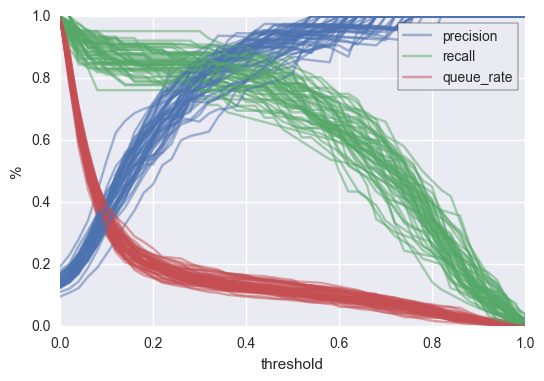

In [9]:
clf = RandomForestClassifier(n_estimators=50, oob_score=True)

n_trials = 50  
test_size_percent = 0.1

signals = df[[c for c in df.columns if c != 'churn']]  
labels = df['churn']

plot_data = []

for trial in range(n_trials):  
    train_signals, test_signals, train_labels, test_labels = train_test_split(signals, labels, test_size=test_size_percent)
    clf.fit(train_signals, train_labels)
    predictions = clf.predict_proba(test_signals)[:,1]

    precision, recall, thresholds = precision_recall_curve(test_labels, predictions)
    thresholds = np.append(thresholds, 1)

    queue_rate = []
    for threshold in thresholds:
        queue_rate.append((predictions >= threshold).mean())

    plot_data.append({
            'thresholds': thresholds
        ,   'precision': precision
        ,   'recall': recall
        ,   'queue_rate': queue_rate
    })

for p in plot_data:  
    plt.plot(p['thresholds'], p['precision'], color=sns.color_palette()[0], alpha=0.5)
    plt.plot(p['thresholds'], p['recall'], color=sns.color_palette()[1], alpha=0.5)
    plt.plot(p['thresholds'], p['queue_rate'], color=sns.color_palette()[2], alpha=0.5)

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')  

As expected, there's some variation. Earlier, when we were just looking at a single train/test split, we said that with a threshold of 0.4, we'd expect:

Queue rate of about 14%.
Precision of about 92%.
Recall of about 80%.
Now we see that there is more uncertainty around these numbers. Looking at the new chart, which shows 50 train/test splits, we might now say instead that a threshold of 0.4 would produce:

A queue rate of between 10% and 20%
Precision of between 70% and 100%
Recall of between 60% and 90%.
We can make more precise statements with a statistical visualization. Let's plot the median curves, along with a 90% central interval for each threshold:



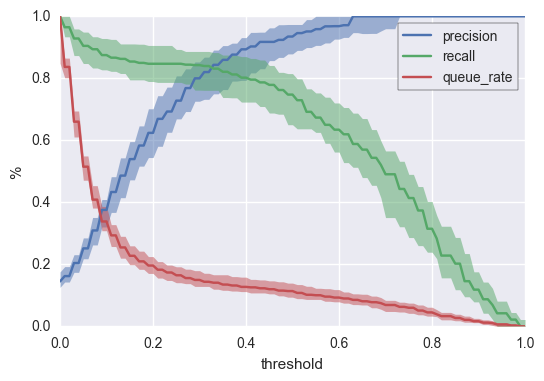

In [10]:
import bisect  
from scipy.stats import mstats

uniform_thresholds = np.linspace(0, 1, 101)

uniform_precision_plots = []  
uniform_recall_plots= []  
uniform_queue_rate_plots= []

for p in plot_data:  
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])

    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

quantiles = [0.1, 0.5, 0.9]  
lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0)  
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0)  
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_precision)  
plt.plot(uniform_thresholds, median_recall)  
plt.plot(uniform_thresholds, median_queue_rate)

plt.fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color=sns.color_palette()[0])  
plt.fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color=sns.color_palette()[1])  
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')  

Now we can be considerably more precise by saying that for a threshold of 0.4, we expect:

A 90% chance that our queue rate will be between ~11% and ~15%, with median value ~13%.
A 90% chance that our precision will be between ~80% and ~95%, with median value ~90%.
A 90% chance that our recall will be between ~70% and ~85% with a median value ~80%.
With this chart, we can say quite a lot about the likely outcomes of different threshold choices under realistic conditions.



Thresholding Like an Owner
One of the things I love about the last chart is that it empowers you to make business decisions based on your ML work. This gives you the opportunity to move beyond the technical role of building a model into the role of deciding what to actually do with your model. All you need to get started is the chart above and some back of the envelope numbers for cost/benefit analysis.

As a simple example, let's say that your company's churn prevention strategy is to make direct phone calls to each churn-risky user (defined as users whose churn score is above the threshold you set). To keep things easy, we'll assume unrealistically that this strategy always works: If a user who was going to churn gets a phone call, he or she will not churn. Your retention team has 3 members, each of whom can make 333 calls per period; so you can make a total of 1000 calls per period. Let's say again that you get 10k cases to score each period, that the cost of labor in making a phone call is $20, and that if a user churns, you lose $100. These estimates need not be perfect for our purposes; we're looking for a back of the envelope calculation.

So right now, on the curve, you're going to set a threshold of about 0.57: That will give you a queue rate of 10.03% = 1003 cases, and that's all you can handle. The chart also shows you uncertainty. You know, e.g., that with a threshold of 0.57, you'll end up between about 8.4% = 840 and 11.4% = 1140 cases. If you know that your team absolutely cannot handle more than 1000 cases, then you should leave some room: Choose a lower threshold (e.g. 0.65) so that the 90% interval lies below your 1000 case limit.

Even more importantly: Because you have your chart, you can see that having a 1000 call capacity is suboptimal for your business; the clue is the fact that recall is so low. Right now, your total cost is around $20 x 1000 = $20,000 and, since your precision is 96%, you're making about 0.96 x $100 x 1000 = $96,000 in saved account "revenue", making the total profit of your operation about $76,000. But what if you doubled your budget? Then you could review 2k cases, your cost would be $40,000, your precision would be about 61% and you'd make 0.61 x $100 x 2000 = $122,000 in revenue, making your profit around $82,000. Your chart just helped you make $6,000 per period.

This was just an educated guess about a better threshold; if we poke around a bit more, we find that the optimal threshold for these specific cost estimates is 0.33, which gives us a median profit of about $90,700.



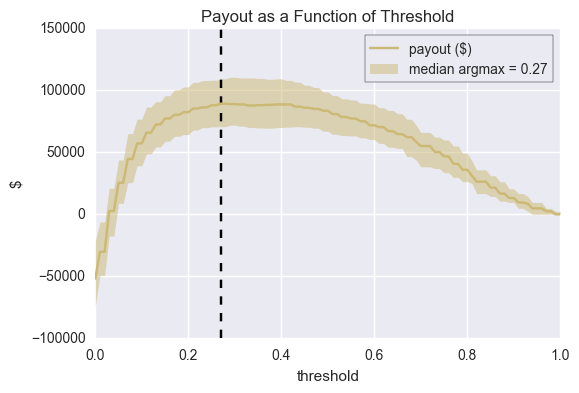

In [14]:

uniform_thresholds = np.linspace(0, 1, 101)

uniform_payout_plots = []

n = 10000
success_payoff = 100
case_cost = 20

for p in plot_data:
    uniform_payout = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        precision = p['precision'][index]
        queue_rate = p['queue_rate'][index]
        
        payout = n*queue_rate*(precision*100 - case_cost)
        uniform_payout.append(payout)

    uniform_payout_plots.append(uniform_payout)

quantiles = [0.1, 0.5, 0.9]
lower_payout, median_payout, upper_payout = mstats.mquantiles(uniform_payout_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_payout, color=sns.color_palette()[4])
plt.fill_between(uniform_thresholds, upper_payout, lower_payout, alpha=0.5, linewidth=0, color=sns.color_palette()[4])

max_ap = uniform_thresholds[np.argmax(median_payout)]
plt.vlines([max_ap], -100000, 150000, linestyles='--')
plt.ylim(-100000, 150000)

leg = plt.legend(('payout ($)', 'median argmax = {:.2f}'.format(max_ap)), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.title("Payout as a Function of Threshold")
plt.ylabel('$')

We can also see that there's a lot of uncertainty in the profitability of our operation; knowing this ahead of time let's you move more confidently when natural variation occurs.

(As a side note, it's worth pointing out too that if we had used the naive value of 0.5 (i.e. queue cases with churn score above 0.5, ignore cases below 0.5), which is a common default value for classifiers, we would have created far less value than we were able to do do by using our thresholding chart. With a threshold of 0.5 and review capacity to match, we would have made about $84,000 rather than $89,200, more than a $5,000 difference per period!)

In general, using the queue rate / precision / recall graph is an easy way to perform "what if" analysis on the operational and strategic decision of how your model can be best used.

Bottom Line
Thresholding is a simple and effective strategy for creating value from a machine learning classifier. Once you've decided to threshold, data visualization techniques like the ones in this post will let you understand the tradeoffs you face for each possible threshold choice -- and thus help you choose the most value-creating threshold for your particular business application.

